# PaddleCamp - 第二期

## 第三周 - 第一次作业 - MNIST（手写数字识别）

本次作业共 **2** 部分：
1. 客观选择题
2. 代码填空题

**作业要求**：

* 客观选择题
1. 该部分共计 **50** 分，共 **10** 个单向选择题，答对一个空则得 **5** 分；
2. 学员要在问卷星上完成作业，答题 **链接**：[https://ks.wjx.top/jq/43778465.aspx](https://ks.wjx.top/jq/43778465.aspx)；
3. 截止时间：**8月13日（周二）22:00**；
4. 晚于该时间将无法作答，该部分计 **0** 分；
5. 多次提交，以 **最后一次** 提交为准；
6. 请大家准确填写 **姓名**、**学号**。学号示例：camp001。

* 代码填空题
1. 该部分满分 **50** 分，共计 **5** 个代码填空题。
2. 根据提示完成空白部分的代码。  
3. 评分细则：

测试精度大于等于99%：**50**分；

测试精度不足99%，但大于等于96%：**40**分；

测试精度不足96%，但程序可以正常运行，并得到训练结果曲线：**30**分；

看不到训练曲线：**0**分。


# PaddlePaddle 实现手写数字识别
欢迎大家来到这次实验，在这次实验中我们将使用 PaddlePaddle 来实现三种不同的分类器，用于识别手写数字。三种分类器所基于的模型分别为 Softmax 回归、多层感知器、卷积神经网络。现在让我们进入实验来看看基于不同模型的分类器的差异吧!

**您将学会**

- 实现一个基于Softmax回归的分类器，用于识别手写数字

- 实现一个基于多层感知器的分类器，用于识别手写数字

- 实现一个基于卷积神经网络的分类器，用于识别手写数字

- 卷积神经网络的基本组成和搭建

现在让我们进入实验吧！


## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：

- numpy：一个python的基本库，用于科学计算
- paddle.fluid：PaddlePaddle深度学习框架
- PIL：Python上的图像处理标准库
- os：在本例中用于获取文件或目录的路径
- Image：用于处理图像数据
- from paddle.utils.plot import Ploter :paddle集成了一个画图工具包，我们可以利用这个包把训练曲线画出来

In [1]:
from __future__ import print_function
import os
from PIL import Image
import matplotlib.pyplot as plt #plt 用于显示图片
import numpy
import paddle
import paddle.fluid as fluid
from paddle.utils.plot import Ploter
%matplotlib inline

**问题描述：**

当我们学习编程的时候，编写的第一个程序一般是实现打印"Hello World"。而机器学习（或深度学习）的入门教程，一般都是 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据库上的手写数字识别问题。原因是手写数字识别属于典型的图像分类问题，比较简单，同时MNIST数据集也很完备。

**你的目标：**

构建三种不同的分类器来对手写数字进行识别

**数据集分析：**

MNIST 数据集作为一个简单的计算机视觉数据集，包含一系列如图1所示的手写数字图片和对应的标签。图片是 28x28 像素的矩阵，标签则对应着0~9的10个数字。每张图片都经过了大小归一化和居中处理。

![](https://ai-studio-static-online.cdn.bcebos.com/6e2ce3e2a6b44f74b9f5a71fd4f0ea818844afec85f34acb8f1d4530b20c67a8)

MNIST数据集是从 [NIST](https://www.nist.gov/srd/nist-special-database-19) 的Special Database 3（SD-3）和Special Database 1（SD-1）构建而来。由于SD-3是由美国人口调查局的员工进行标注，SD-1是由美国高中生进行标注，因此SD-3比SD-1更干净也更容易识别。Yann LeCun等人从SD-1和SD-3中各取一半作为MNIST的训练集（60000条数据）和测试集（10000条数据），其中训练集来自250位不同的标注员，此外还保证了训练集和测试集的标注员是不完全相同的。

Yann LeCun早先在手写字符识别上做了很多研究，并在研究过程中提出了卷积神经网络（Convolutional Neural Network），大幅度地提高了手写字符的识别能力，也因此成为了深度学习领域的奠基人之一。如今的深度学习领域，卷积神经网络占据了至关重要的地位，从最早Yann LeCun提出的简单LeNet，到如今ImageNet大赛上的优胜模型VGGNet、GoogLeNet、ResNet等（请参见[图像分类](https://github.com/PaddlePaddle/book/tree/develop/03.image_classification) 教程），人们在图像分类领域，利用卷积神经网络得到了一系列惊人的结果。

有很多算法在 MNIST 上进行实验。1998年，LeCun 分别用单层线性分类器、多层感知器（Multilayer Perceptron, MLP）和多层卷积神经网络LeNet进行实验，使得测试集上的误差不断下降（从12%下降到0.7%）\[[1](#参考文献)\]。此后，科学家们又基于K近邻（K-Nearest Neighbors）算法\[[2](#参考文献)\]、支持向量机（SVM）\[[3](#参考文献)\]、神经网络\[[4-7](#参考文献)\]和Boosting方法\[[8](#参考文献)\]等做了大量实验，并采用多种预处理方法（如去除歪曲、去噪、模糊等）来提高识别的准确率。

本教程中，我们从简单的模型 Softmax 回归开始，带大家入门手写数字识别，并逐步进行模型优化。

输入值：

- $X$是输入：MNIST图片是$28\times28$ 的二维图像，为了进行计算，我们将其转化为 $784$ 维向量，即 𝑋=(𝑥0,𝑥1,…,𝑥783) 。转化的具体做法：每张图片是由 $28\times28$ 个像素构成的，将其按固定顺序（如按行或者按列）展开成为一个行向量，并将每个原始像素值归一化为$\left[0,1\right]$ 之间的数值。

- $L$是图片的真实标签：𝐿=(𝑙0,𝑙1,…,𝑙9)也是10维，但只有一维为1，其他都为0。值为1的维度对应图片表示的真实数字，例如𝐿=(1,0,…,0)表示图片对应的数字是1。

输出值：

- $Y$是输出：分类器的输出是 10 类数字（0-9），即 𝑌=(𝑦0,𝑦1,…,𝑦9)，每一维 $y_i$ 代表图片分类为第 $i$ 类数字的概率。

要注意的是，PaddlePaddle将图像的通道数放在最前面，即为[C H W]，区别于[H W C]。



## 2 - 数据获取

**文件路径**

在该项目中，已为大家准备好数据集，路径：/home/aistudio/dataset/

数据集信息如下：


|    文件名称          |       说明              |
|----------------------|-------------------------|
|train-images-idx3-ubyte|  训练数据图片，60,000条数据 |
|train-labels-idx1-ubyte|  训练数据标签，60,000条数据 |
|t10k-images-idx3-ubyte |  测试数据图片，10,000条数据 |
|t10k-labels-idx1-ubyte |  测试数据标签，10,000条数据 |




In [2]:
# 定义reader，用于获取数据集数据

import struct
import gzip

TRAIN_IMAGE = "/home/aistudio/data/data65/train-images-idx3-ubyte.gz"
TRAIN_LABEL = "/home/aistudio/data/data65/train-labels-idx1-ubyte.gz"
TEST_IMAGE = "/home/aistudio/data/data65/t10k-images-idx3-ubyte.gz"
TEST_LABEL = "/home/aistudio/data/data65/t10k-labels-idx1-ubyte.gz"


def reader_creator(image_filename, label_filename, buffer_size):
    def reader():
        with gzip.GzipFile(image_filename, 'rb') as image_file:
            img_buf = image_file.read()
            with gzip.GzipFile(label_filename, 'rb') as label_file:
                lab_buf = label_file.read()

                step_label = 0

                offset_img = 0
                # read from Big-endian
                # get file info from magic byte
                # image file : 16B
                magic_byte_img = '>IIII'
                magic_img, image_num, rows, cols = struct.unpack_from(
                    magic_byte_img, img_buf, offset_img)
                offset_img += struct.calcsize(magic_byte_img)

                offset_lab = 0
                # label file : 8B
                magic_byte_lab = '>II'
                magic_lab, label_num = struct.unpack_from(magic_byte_lab,
                                                          lab_buf, offset_lab)
                offset_lab += struct.calcsize(magic_byte_lab)

                while True:
                    if step_label >= label_num:
                        break
                    fmt_label = '>' + str(buffer_size) + 'B'
                    labels = struct.unpack_from(fmt_label, lab_buf, offset_lab)
                    offset_lab += struct.calcsize(fmt_label)
                    step_label += buffer_size

                    fmt_images = '>' + str(buffer_size * rows * cols) + 'B'
                    images_temp = struct.unpack_from(fmt_images, img_buf,
                                                     offset_img)
                    images = numpy.reshape(images_temp, (
                        buffer_size, rows * cols)).astype('float32')
                    offset_img += struct.calcsize(fmt_images)

                    images = images / 255.0 * 2.0 - 1.0
                    for i in range(buffer_size):
                        yield images[i, :], int(labels[i])

    return reader


def train():
    """
    MNIST training set creator.

    It returns a reader creator, each sample in the reader is image pixels in
    [0, 1] and label in [0, 9].

    :return: Training reader creator
    :rtype: callable
    """
    return reader_creator(TRAIN_IMAGE, TRAIN_LABEL, 100)

def test():
    """
    MNIST test set creator.

    It returns a reader creator, each sample in the reader is image pixels in
    [0, 1] and label in [0, 9].

    :return: Test reader creator.
    :rtype: callable
    """
    return reader_creator(TEST_IMAGE, TEST_LABEL, 100)

## 3 - 知识点介绍

### 3.1 常见激活函数介绍  

- sigmoid激活函数： 
$$ f(x) = sigmoid(x) = \frac{1}{1+e^{-x}} $$

- tanh激活函数： 
$$ f(x) = tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} $$

  实际上，tanh函数只是规模变化的sigmoid函数，将sigmoid函数值放大2倍之后再向下平移1个单位：tanh(x) = 2sigmoid(2x) - 1 。

- ReLU激活函数：
$$ f(x) = max(0, x) $$

更详细的介绍请参考[维基百科激活函数](https://en.wikipedia.org/wiki/Activation_function)。



### 3.2 - Softmax回归(Softmax Regression)

最简单的Softmax回归模型是先将输入层经过一个全连接层得到的特征，然后直接通过softmax 函数进行多分类\[[9](#参考文献)\]。

输入层的数据$X$传到输出层，在激活操作之前，会乘以相应的权重 $W$ ，并加上偏置变量 $b$ ，具体如下：

$$ y_i = \text{softmax}(\sum_j W_{i,j}x_j + b_i) $$

其中 
$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}} $$

对于有 $N$ 个类别的多分类问题，指定 $N$ 个输出节点，$N$ 维结果向量经过softmax将归一化为 $N$ 个[0,1]范围内的实数值，分别表示该样本属于这 $N$ 个类别的概率。此处的 $y_i$ 即对应该图片为数字 $i$ 的预测概率。

在分类问题中，我们一般采用交叉熵代价损失函数（cross entropy），公式如下：

$$  \text{crossentropy}(label, y) = -\sum_i label_ilog(y_i) $$

图2为softmax的网络图，图中权重用蓝线表示、偏置用红线表示、+1代表偏置参数的系数为1。

![](https://ai-studio-static-online.cdn.bcebos.com/2b68a18d039846df94a2c7933339373cebe9b62830ea47cd84bfaff530f2f410)


### 3.3 - 多层感知器(Multilayer Perceptron, MLP)

Softmax回归模型采用了最简单的两层神经网络，即只有输入层和输出层，因此其拟合能力有限。为了达到更好的识别效果，我们考虑在输入层和输出层中间加上若干个隐藏层\[[10](#参考文献)\]。

1.  经过第一个隐藏层，可以得到 𝐻1=𝜙(𝑊1𝑋+𝑏1) ，其中𝜙 代表激活函数，常见的有sigmoid、tanh或ReLU等函数。
2.  经过第二个隐藏层，可以得到𝐻2=𝜙(𝑊2𝐻1+𝑏2)。
3.  最后，再经过输出层，得到的𝑌=softmax(𝑊3𝐻2+𝑏3)，即为最后的分类结果向量。


图3为多层感知器的网络结构图，图中权重用蓝线表示、偏置用红线表示、+1代表偏置参数的系数为1。

![](https://ai-studio-static-online.cdn.bcebos.com/c3d04b6795944553ac066f3e05ba1842b0606a4952e04f839ff23a38e6abbc20)




### 3.4 - 卷积神经网络(Convolutional Neural Network, CNN)

在多层感知器模型中，将图像展开成一维向量输入到网络中，忽略了图像的位置和结构信息，而卷积神经网络能够更好的利用图像的结构信息。[LeNet-5](http://yann.lecun.com/exdb/lenet/)是一个较简单的卷积神经网络。下图显示了其结构：输入的二维图像，先经过两次卷积层到池化层（降采样层），再经过全连接层，最后使用softmax函数作为输出层激活函数。下面我们主要介绍卷积层和池化层。

![](https://ai-studio-static-online.cdn.bcebos.com/ee8bbb54a2f0416587e184611d3bea33e5f44644b82d4e869f21a2961117e264)



#### 卷积层

卷积层是卷积神经网络的核心基石。在图像识别里我们提到的卷积是二维卷积，即离散二维滤波器（也称作卷积核）与二维图像做卷积操作，简单的讲是二维滤波器滑动到二维图像上所有位置，并在每个位置上与该像素点及其领域像素点做内积。卷积操作被广泛应用与图像处理领域，不同卷积核可以提取不同的特征，例如边沿、线性、角等特征。在深层卷积神经网络中，通过卷积操作可以提取出图像低级到复杂的特征。

![](https://ai-studio-static-online.cdn.bcebos.com/7fb741abc89c4820802caf0715fd356a59adae2ae4dc4ad6a178c81ef1f89db3)
<center>图5. 卷积层图片<br/></center>

上图5给出一个卷积计算过程的示例图，输入图像大小为$H=5,W=5,D=3$，即$5 \times 5$大小的3通道（RGB，也称作深度）彩色图像。这个示例图中包含两（用$K$表示）组卷积核，即图中滤波器$W_0$和$W_1$。在卷积计算中，通常对不同的输入通道采用不同的卷积核，如图示例中每组卷积核包含（$D=3）$个$3 \times 3$（用$F \times F$表示）大小的卷积核。另外，这个示例中卷积核在图像的水平方向（$W$方向）和垂直方向（$H$方向）的滑动步长为2（用$S$表示）；对输入图像周围各填充1（用$P$表示）个0，即图中输入层原始数据为蓝色部分，灰色部分是进行了大小为1的扩展，用0来进行扩展。经过卷积操作得到输出为$3 \times 3 \times 2$（用$H_{o} \times W_{o} \times K$表示）大小的特征图，即$3 \times 3$大小的2通道特征图，其中$H_o$计算公式为：$H_o = (H - F + 2 \times P)/S + 1$，$W_o$同理。 而输出特征图中的每个像素，是每组滤波器与输入图像每个特征图的内积再求和，再加上偏置$b_o$，偏置通常对于每个输出特征图是共享的。输出特征图$o[:,:,0]$中的最后一个$-2$计算如图中右下角公式所示。

在卷积操作中卷积核是可学习的参数，经过上面示例介绍，每层卷积的参数大小为$D \times F \times F \times K$。在多层感知器模型中，神经元通常是全部连接，参数较多。而卷积层的参数较少，这也是由卷积层的主要特性即局部连接和共享权重所决定。

- 局部连接：每个神经元仅与输入神经元的一块区域连接，这块局部区域称作感受野（receptive field）。在图像卷积操作中，即神经元在空间维度（spatial dimension，即上图示例H和W所在的平面）是局部连接，但在深度上是全部连接。对于二维图像本身而言，也是局部像素关联较强。这种局部连接保证了学习后的过滤器能够对于局部的输入特征有最强的响应。局部连接的思想，也是受启发于生物学里面的视觉系统结构，视觉皮层的神经元就是局部接受信息的。

- 权重共享：计算同一个深度切片的神经元时采用的滤波器是共享的。例如图4中计算$o[:,:,0]$的每个每个神经元的滤波器均相同，都为$W_0$，这样可以很大程度上减少参数。共享权重在一定程度上讲是有意义的，例如图片的底层边缘特征与特征在图中的具体位置无关。但是在一些场景中是无意的，比如输入的图片是人脸，眼睛和头发位于不同的位置，希望在不同的位置学到不同的特征 (参考[斯坦福大学公开课]( http://cs231n.github.io/convolutional-networks/))。请注意权重只是对于同一深度切片的神经元是共享的，在卷积层，通常采用多组卷积核提取不同特征，即对应不同深度切片的特征，不同深度切片的神经元权重是不共享。另外，偏重对同一深度切片的所有神经元都是共享的。

通过介绍卷积计算过程及其特性，可以看出卷积是线性操作，并具有平移不变性（shift-invariant），平移不变性即在图像每个位置执行相同的操作。卷积层的局部连接和权重共享使得需要学习的参数大大减小，这样也有利于训练较大卷积神经网络。



#### 池化层


![](https://ai-studio-static-online.cdn.bcebos.com/5e7611a948444cee977b0fe866fb75e61ce6a4335dc34abd8b8cf79caef5fde2)

一般情况下，在连续的卷积层之间会周期性地插入一个池化层（也称汇聚层），其处理输入数据的准则被称为池化函数。池化函数在计算某一位置的输出时，会计算该位置相邻区域的输出的某种总体统计特征，作为网络在该位置的输出。池化层的作用是逐渐降低数据体的空间尺寸，从而减少网络中参数的数量以及耗费的计算资源，同时也能有效控制过拟合。

池化包括最大池化、平均池化、L-2范数池化等。以最大池化(Max Pooling)为例，池化层使用最大化(Max)操作，即用一定区域内输入的最大值作为该区域的输出。最大池化最常用的形式是使用尺寸为$2\times2$的滤波器、步长为2来对每个深度切片进行降采样，每个Max操作是从4个数字中取最大值（也就是在深度切片中某个的区域），这样可以将其中75%的激活信息都过滤掉，而保持数据体通道数不变,具体示例如图6所示。

更详细的关于卷积神经网络的具体知识可以参考[斯坦福大学公开课]( http://cs231n.github.io/convolutional-networks/ )和[图像分类](https://github.com/PaddlePaddle/book/blob/develop/image_classification/README.md)教程。

## 4 - 构建分类器

我们利用PaddlePaddle构建三个不同的分类器：

### 4.1 Softmax回归：

只通过一层简单的以Softmax为激活函数的全连接层得到分类结果。具体过程和网络结构如图7所示：784维的输入特征经过节点数目为10的全连接层后，直接通过Softmax函数进行多分类。

![](https://ai-studio-static-online.cdn.bcebos.com/3e76fab1ffed412aa142ee820dab4bc10c82d9daec714307a701887b91c1c92a)

按照上述描述实现 Softmax 回归分类器对应的 softmax_regression() 函数。


> API 解释
> 全连接 通常写法为 hidden = fluid.layers.fc(input=x, size=10, act='sigmoid')
> 

In [3]:
def softmax_regression(img):
    """
    定义softmax分类器：
        一个以softmax为激活函数的全连接层
    :param img: 输入层
    :Return:
        predict -- 分类的结果
    """
    
	# 以softmax为激活函数的全连接层，输出层的大小必须为数字的个数10    
    predict = fluid.layers.fc(input=img, size=10, act='softmax')
    return predict

### 4.2 多层感知器：

下面代码实现了一个含有两个隐藏层（即全连接层）的多层感知器。其中两个隐藏层的激活函数均采用ReLU，输出层的激活函数用 Softmax。Softmax 回归模型采用了最简单的两层神经网络，即只有输入层和输出层，因此其拟合能力有限。为了达到更好的识别效果，我们考虑在输入层和输出层中间加上若干个隐藏层,从而得到了多层感知器模型。其对应的网络结构如图8所示：784维的输入特征，先后经过两个节点数为128和64的全连接层，最后通过 Softmax 函数进行多分类。

![](https://ai-studio-static-online.cdn.bcebos.com/b48906f74aec4e5ab172202ba587ff3927a29436653e4ff6bcdc9e0cd82a1c28)

按照上述描述定义多层感知器模型对应的函数 multilayer_perceptron()。

> API 解释
> 全连接 通常写法为 hidden = fluid.layers.fc(input=x, size=10, act='sigmoid')
> 

In [4]:
def multilayer_perceptron(img):
    """
    定义多层感知机分类器：
        含有两个隐藏层（全连接层）的多层感知器
        其中前两个隐藏层的激活函数采用 ReLU，输出层的激活函数用 Softmax

    :param img: 输入层
    Return:
        predict_image -- 分类的结果
    """
    # 第一个全连接层，本层神经元有128个 激活函数为 ReLU 
    h1 = fluid.layers.fc(input=img, size=128, act='relu')    
    # 第二个全连接层，本层神经元有64个 激活函数为 ReLU 
    hidden = fluid.layers.fc(input=h1, size=64, act='relu')
    # 以 softmax 为激活函数的全连接输出层，输出层的大小必须为 10,对应 0-9 这 10 个数字
    prediction = fluid.layers.fc(input=hidden, size=10, act='softmax')
    return prediction

### 4.3 卷积神经网络: 

卷积网络的结构示意图如下所示：

![](https://ai-studio-static-online.cdn.bcebos.com/1a45678fb45c4a7887aac306ceda3bdf7d9002a04feb4e8e9ea625a4651bf09c)

比如本次实验，输入的二维图像，可以经过两次卷积层后接池化层的结构，在通过输出节点数目为10的以Softmax函数作为激活函数的全连接层后得到多分类输出。  

**练习1—3：**

根据上述描述和图示，补全下面练习1—3处的代码，实现卷积神经网络模型对应的函数 convolutional_neural_network()。


> **API 解释**  
> **卷积** 通常写法为 `hidden = fluid.nets.simple_img_conv_pool(input, num_filters, filter_size, pool_size, pool_stride, pool_padding=0)`
>
要注意的是，PaddlePaddle将图像的通道数放在最前面，即为[C H W]，区别于[H W C]。

其中: 
> input - 输入   
> num_filters - filters 的数量  
> filter_size - filter 的大小  
> pool_size - 池化的大小  
> pool_stride - 池化的步长  
> pool_padding - 池化的 padding 
    
建议适当调节这些参数，以达到训练精度要求。
> API 参考文档：[http://paddlepaddle.org/documentation/docs/zh/1.4/api_cn/nets_cn.html](http://paddlepaddle.org/documentation/docs/zh/1.4/api_cn/nets_cn.html)



In [5]:
#练习1—3：
#要求：根据上述描述和图示，补全下面代码，实现卷积神经网络模型对应的函数 convolutional_neural_network()。
def convolutional_neural_network(img):
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层
    
    :param img: 输入层
    Return:
        prediction -- 分类的结果
    """

    #练习1：
    #使用fluid.nets.simple_img_conv_pool()函数，完成第一个卷积-池化层
    # 根据需求，自己设定参数
    ### 练习1代码开始处 ### 
    img = fluid.layers.data(name='img', shape=[1, 28, 28], dtype='float32')
    h1 = fluid.nets.simple_img_conv_pool(input=img,
                                        filter_size=3,
                                        num_filters=50,
                                        pool_size=2,
                                        pool_stride=2,
                                        pool_padding=0,
                                        act = "relu")
    ### 练习1代码结束处 ###

    
    #练习2：
    # 使用fluid.nets.simple_img_conv_pool()函数，完成第二个卷积-池化层
    # 根据需求，自己设定参数
    ### 练习2代码开始处 ### 
    h2 =  fluid.nets.simple_img_conv_pool(input=h1,
                                        filter_size=3,
                                        num_filters=50,
                                        pool_size=2,
                                        pool_stride=2,
                                        pool_padding=0,
                                        act = "relu")
    ### 练习2代码结束处 ###
#    h3 = fluid.nets.simple_img_conv_pool(input = h2,
#                                         filter_size = 3,
#                                         num_filters = 20,
#                                         pool_size =2 ,
#                                         pool_stride = 2 ,
#                                         pool_padding=0,
#                                         act = "relu")

    #练习3：
    # 使用fluid.layers.fc(----------)函数，完成最后全连接层预测输出
    # 根据需求，自己设定参数
    ### 练习3代码开始处 ### 
    prediction = fluid.layers.fc(input=h2, size=10, act='softmax')
    ### 练习3代码结束处 ###
    
    return prediction
print("ok")

ok


为了在训练的时候，我们能实时的观察到模型训练效果，我们可以用一个画图函数，把训练曲线展示出来。这个函数我们定义为：

`event_handler_plot(ploter_title, step, cost)`

In [6]:
train_prompt = "Train cost"
test_prompt = "Test cost"
cost_ploter = Ploter(train_prompt, test_prompt)

# 将训练过程绘图表示
def event_handler_plot(ploter_title, step, cost):
    cost_ploter.append(ploter_title, step, cost)
    cost_ploter.plot()
print("OK")

OK


## 5 - 训练过程
### 5.1 配置网络结构：
接下来需要配置分类网络的结构：
> - 首先通过 layers.data 配置数据输入层，  
> - 然后配置分类器（代码中提供了三个不同的分类器，每次使用选择其中一个，注释掉其余两个即可）。例如下方代码中选用的是卷积神经网络分类器。 
> - 然后设置损失函数，对于分类问题常常选择交叉熵损失函数。

In [7]:
# 数据输入层
img = fluid.layers.data(name='img', shape=[1, 28, 28], dtype='float32')
# 标签层，名称为label,对应输入图片的类别标签
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

#prediction = softmax_regression(img) # 取消注释将使用 Softmax回归
#prediction = multilayer_perceptron(img) # 取消注释将使用 多层感知器
prediction = convolutional_neural_network(img) # 取消注释将使用 卷积神经网络

# 使用类交叉熵函数计算predict和label之间的损失函数
cost = fluid.layers.cross_entropy(input=prediction, label=label)
# 计算平均损失
avg_loss = fluid.layers.mean(cost)
#注意：这个平均损失avg_loss，在下面的优化器optimizer中要用到，optimizer.minimize(avg_loss)

# 计算分类准确率
acc = fluid.layers.accuracy(input=prediction, label=label)
print("done")

done


设置test_program ：

我们通过克隆main_program得到test_program  
为什要要这样做呢？因为有些operator在训练和测试之间的操作是不同的，例如batch_norm，使用参数for_test来区分该程序是用来训练还是用来测试。  
另外：该api不会删除任何操作符,请在backward和optimization之前使用

In [8]:
test_program = fluid.default_main_program().clone(for_test=True)

### 5.2 创建优化器 
 

参数创建完成后，我们需要定义一个优化器optimizer，为了改善模型的训练速度以及效果，学术界先后提出了很多优化算法，包括： Momentum、RMSProp、Adam 等，已经被封装在fluid内部，读者可直接调用。比如，Adam就是一种常用的、效果良好的自适应学习率调整优化算法，在 fluid 中可以使用接口 fluid.optimizer.Adam() 来创建 Adam 优化器。这个函数接受 4个参数分别是：learning_rate, beta1, beta2 和 epsilon。


如果使用Adam优化器，可参考如下代码：

```python
optimizer = fluid.optimizer.Adam(learning_rate=0.1)
optimizer.minimize(avg_loss)
```

你还可以尝试使用其他优化器，来看看效果如何。相关的API在这里：[http://paddlepaddle.org/documentation/docs/zh/1.4/api_cn/optimizer_cn.html](http://paddlepaddle.org/documentation/docs/zh/1.4/api_cn/optimizer_cn.html)

**练习4：**   

补全代码，完成优化器的配置。


In [9]:
#练习4：补全代码，完成优化器的配置；
#提示：你也可以尝试使用其他优化器，也可以适当的配置相关参数，尤其是learning_rate，对训练结果有一定影响
### 练习代码开始处 ### （≈2行代码）
optimizer = fluid.optimizer.Adam(learning_rate=0.001)
optimizer.minimize(avg_loss)

### 练习代码结束处 ### 
print("optimizer is ready")

optimizer is ready


In [10]:
#我们还可以定义一个train_test()函数，使用测试数据，来测试训练效果。
def train_test(train_test_program, train_test_feed, train_test_reader):
     # 将分类准确率存储在acc_set中
    acc_set = []
    # 将平均损失存储在avg_loss_set中
    avg_loss_set = []
    # 将测试 reader yield 出的每一个数据传入网络中进行训练
    for test_data in train_test_reader():
        acc_np, avg_loss_np = exe.run(
            program=train_test_program,
            feed=train_test_feed.feed(test_data),
            fetch_list=[acc, avg_loss])
        acc_set.append(float(acc_np))
        avg_loss_set.append(float(avg_loss_np))
    # get test acc and loss
     # 获得测试数据上的准确率和损失值
    acc_val_mean = numpy.array(acc_set).mean()
    avg_loss_val_mean = numpy.array(avg_loss_set).mean()
    # 返回平均损失值，平均准确率
    return avg_loss_val_mean, acc_val_mean 
print("done")

done



### 5.3 设置训练场所 

下面设置训练使用的设备。在复杂量较低的时候使用 CPU 就可以完成任务，但是对于大规模计算就需要使用 GPU 训练。目前 GPU 训练都是基于 CUDA 工具之上的。  

例如：  

> - 示例如下：
```python
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()
```
> - use_cuda=False 表示不使用 GPU 进行训练  
> - fluid.CUDAPlace(i) (i 代表 the GPU id)；如果向CPU中输入数据, 请使用 fluid.CPUPlace()  


**练习5：**  
补全下面代码，完成训练场所的设置：

In [11]:
#练习5：
# 补全代码，完成训练场所的设置。
#要求：工作场所变量名称为place
### 练习代码开始处 ### （≈2行代码）
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()

### 练习代码结束处 ###

### 5.4 读取数据集
paddle.dataset.mnist.train()和paddle.dataset.mnist.test()分别做训练和测试数据集。这两个函数各自返回一个reader——PaddlePaddle中的reader是一个Python函数，每次调用的时候返回一个Python yield generator。

下面shuffle是一个reader decorator，它接受一个reader A，返回另一个reader B。reader B 每次读入buffer_size条训练数据到一个buffer里，然后随机打乱其顺序，并且逐条输出。

batch是一个特殊的decorator，它的输入是一个reader，输出是一个batched reader。在PaddlePaddle里，一个reader每次yield一条训练数据，而一个batched reader每次yield一个minibatch。

In [12]:
# 一个minibatch中有64个数据
BATCH_SIZE = 128 #BATCH_SIZE

# 每次读取训练集中的500个数据并随机打乱，传入batched reader中，batched reader 每次 yield 64个数据
train_reader = paddle.batch(
    paddle.reader.shuffle(train(), buf_size=1000),
    batch_size=BATCH_SIZE)

# 读取测试集的数据，每次 yield 64个数据
test_reader = paddle.batch(
    paddle.reader.shuffle(test(), buf_size=1000),
    batch_size=BATCH_SIZE)

feeder = fluid.DataFeeder(feed_list=[img, label], place=place)

print("done")

done


In [13]:
#创建执行器：
exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

#设置 main_program
main_program = fluid.default_main_program()

In [14]:
#设置训练过程的超参：
PASS_NUM = 40 #设置训练样本训练的总 n 轮数，这个参数可以根据需要进行改动，以达到我们需要的训练效果

# 将模型参数存储在名为 save_dirname 的文件中
save_dirname = "saved_model"


**设置训练主循环**  

我们构建一个循环来进行训练，直到训练结果足够好或者循环次数足够多。 如果训练迭代次数满足参数保存的迭代次数，可以把训练参数保存到params_dirname。 

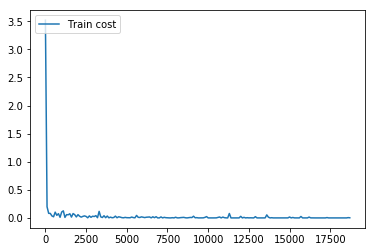

Test with Epoch 0, avg_cost: 0.07587492827302482, acc: 0.9761669303797469
Test with Epoch 1, avg_cost: 0.06300495164704663, acc: 0.9795292721518988
Test with Epoch 2, avg_cost: 0.05057332898148253, acc: 0.982693829113924
Test with Epoch 3, avg_cost: 0.047142699237064094, acc: 0.9847705696202531
Test with Epoch 4, avg_cost: 0.04603976648023847, acc: 0.9854628164556962
Test with Epoch 5, avg_cost: 0.044879303967338524, acc: 0.9851661392405063
Test with Epoch 6, avg_cost: 0.054598590290568814, acc: 0.9841772151898734
Test with Epoch 7, avg_cost: 0.04820428585469328, acc: 0.9861550632911392
Test with Epoch 8, avg_cost: 0.04906094929625581, acc: 0.9849683544303798
Test with Epoch 9, avg_cost: 0.04829062612011109, acc: 0.9864517405063291
Test with Epoch 10, avg_cost: 0.05202953210152108, acc: 0.9852650316455697
Test with Epoch 11, avg_cost: 0.045696829170417085, acc: 0.9880340189873418
Test with Epoch 12, avg_cost: 0.05046903655593154, acc: 0.9873417721518988
Test with Epoch 13, avg_cost: 0.

<Figure size 432x288 with 0 Axes>

In [15]:
epochs = [epoch_id for epoch_id in range(PASS_NUM)]

lists = []
step = 0
for epoch_id in epochs:
    for step_id, data in enumerate(train_reader()):
        metrics = exe.run(
            main_program,
            feed=feeder.feed(data),
            fetch_list=[avg_loss, acc])
        #我们可以把训练结果打印输出，也可以用画图展示出来
        if step % 100 == 0: #每训练100次 打印一次log，或者添加一个绘图点
            #print("Pass %d, Batch %d, Cost %f" % (step, epoch_id, metrics[0]))
            event_handler_plot(train_prompt, step, metrics[0])
        step += 1
    # test for epoch
    # 测试每个epoch的分类效果
    avg_loss_val, acc_val = train_test(
        train_test_program=test_program,
        train_test_reader=test_reader,
        train_test_feed=feeder)

    print("Test with Epoch %d, avg_cost: %s, acc: %s" %
          (epoch_id, avg_loss_val, acc_val))
    lists.append((epoch_id, avg_loss_val, acc_val))
    
    # 保存训练好的模型参数用于预测
    if save_dirname is not None:
        fluid.io.save_inference_model(
            save_dirname, ["img"], [prediction],
            exe)



In [16]:
#我们从训练好的模型中，找到acc值最好的：
# find the best pass
# 选择效果最好的pass
best = sorted(lists, key=lambda list: float(list[2]))[-1]
print('Best pass is %s, testing Avgcost is %s' % (best[0], best[1]))
print('The classification accuracy is %.2f%%' % float((best[2]) * 100))

Best pass is 33, testing Avgcost is 0.066284944122382
The classification accuracy is 99.07%


训练过程是完全自动的，  

Pass表示训练轮次，Batch表示训练全量数据的次数，cost表示当前pass的损失值。

每训练完一个Epoch后，计算一次平均损失和分类准确率。

## 6 - 应用模型
模型训练好之后，我们可以使用训练好的模型对手写体数字图片进行分类，下面程序展示了如何使用训练好的模型进行推断。

**首先**，定义一个用来处理输入的图片的函数 load_image(file)。 它会将输入的图片处理成满足分类器输入要求的格式。

In [17]:
def load_image(file):
    im = Image.open(file).convert('L')
    #因为mnist数据集是28*28的，所以我们最好把预测图片的也resize成（28、28的）
    im = im.resize((28, 28), Image.ANTIALIAS)
    #并且我么也需要把预测图片reshpe成（1,1,28,28），第一个1表示是一张图片，第二个1表示是单通道灰度图，后面两个28还是图片的H/W
    #并且我们需要把数据类型变成float32
    im = numpy.array(im).reshape(1, 1, 28, 28).astype(numpy.float32)
    #因为训练的时候我们的图片进行了归一化处理，所以预测时我们也做一下归一化。
    im = im / 255.0 * 2.0 - 1.0
    return im


In [18]:
#加载图片
tensor_img = load_image("/home/aistudio/data/data2304/infer_3.png")

![](data/data2304/infer_3.png)

测试图片：infer_3.png

**然后**，开始预测，并输出结果  

我们通过`load_inference_model`来设置预测用的网络。我们可以简单地插入在此之前定义的分类器。

In [19]:
inference_scope = fluid.core.Scope()
with fluid.scope_guard(inference_scope):
    # 使用 fluid.io.load_inference_model 获取 inference program,
    # feed_target_names 用于指定需要传入网络的变量名
    # fetch_targets 指定希望从网络中fetch出的变量名
    [inference_program, feed_target_names,
     fetch_targets] = fluid.io.load_inference_model(
         save_dirname, exe)
    
    
    # 开始预测
    results = exe.run(
        inference_program,
        # 将预测数据封装为字典格式：{feed_target_name: feed_target_data}
        feed={feed_target_names[0]: tensor_img},
        fetch_list=fetch_targets)
    # 获取
    lab = numpy.argsort(results)
    print("Inference result of image/infer_3.png is: %d" % lab[0][0][-1])
    

    # 将feed构建成字典 {feed_target_name: feed_target_data}
    # 结果将包含一个与fetch_targets对应的数据列表
    # 我们可以实现批量预测，通过一个循环，每次预测一个mini_batch
    for mini_batch in test_reader():
    #    test_x = numpy.array([data[0] for data in mini_batch]).astype("float32")
        test_x = numpy.array([data[0].reshape(1, 28, 28) for data in mini_batch]).astype("float32")
        test_y = numpy.array([data[1] for data in mini_batch]).astype("int64")
        # 真实进行预测
        mini_batch_result = exe.run(
            inference_program,
            feed={feed_target_names[0]: test_x},
            fetch_list=fetch_targets)
        
        # 打印预测结果
        mini_batch_result = numpy.argsort(mini_batch_result) #找出可能性最大的列标，升序排列
        mini_batch_result = mini_batch_result[0][:, -1]  #把这些列标拿出来
        print('预测结果：%s'%mini_batch_result)

        # 打印真实结果  
        label = test_y # 转化为 label
        print('真实结果：%s'%label)
        
    #计数
    label_len = len(label)
    right_counter = 0
    for i in range(label_len):
        if mini_batch_result[i] == label[i]:
            right_counter += 1
    
    ratio = (right_counter/label_len)
    print("准确率为：%.2f%%"%(ratio*100))

Inference result of image/infer_3.png is: 3
预测结果：[2 2 6 2 0 3 5 5 7 9 3 3 7 1 2 9 6 9 9 6 8 7 0 2 7 0 3 9 1 5 3 4 4 1 1 0 1
 0 5 7 7 4 3 5 8 2 0 0 7 5 4 7 4 9 2 4 1 2 1 7 6 6 9 3 1 0 0 1 5 4 7 7 9 3
 5 2 3 9 4 0 2 5 5 1 2 6 0 2 8 0 4 8 9 3 8 8 0 3 1 8 0 0 8 7 5 3 1 1 2 2 4
 6 4 4 3 7 6 1 2 3 0 3 6 4 0 1 3 6]
真实结果：[2 2 6 2 0 3 5 5 7 9 3 3 7 1 2 9 6 9 9 6 8 7 0 2 7 0 3 9 1 5 3 4 4 1 1 0 1
 0 5 7 7 6 3 5 8 2 0 0 7 5 4 7 4 9 2 4 1 2 1 7 6 6 9 3 1 0 0 2 5 4 7 7 9 3
 3 2 3 9 4 0 2 5 5 1 2 6 0 2 8 0 4 8 9 3 8 8 0 3 1 8 0 0 8 7 5 3 1 1 2 2 4
 6 4 4 3 7 6 1 2 3 0 3 6 4 0 1 3 6]
预测结果：[4 6 9 1 3 1 3 5 4 9 0 5 2 7 9 4 4 5 5 3 5 2 5 4 6 7 5 6 7 0 3 3 3 2 5 9 1
 0 9 4 9 3 8 7 0 2 3 5 9 8 3 5 9 4 0 7 3 5 3 5 2 2 0 5 9 8 4 0 2 0 6 4 2 4
 3 3 2 6 9 3 7 2 1 7 9 1 2 8 0 3 7 3 3 9 5 9 3 3 4 1 9 6 3 6 1 8 9 7 4 6 0
 0 4 8 7 0 2 1 5 9 6 2 5 9 7 4 6 4]
真实结果：[4 6 9 1 3 1 3 5 4 9 0 5 2 7 9 4 4 5 5 3 5 2 5 4 6 7 5 6 7 0 3 3 3 2 5 9 1
 0 9 4 9 3 8 7 0 2 3 5 9 8 3 5 9 4 0 7 3 9 3 5 2 2 0 5 9 8 4 0 2 0 6 4 2 4
 3 

## 7 - 总结

通过这个练习我们学习了：

 如何利用PaddlePaddle搭建CNN卷及网络，并调用相关的的API接口对图片进行特征提取和分类


本节课搭建的卷积神经网络是最基础的卷积模型，后续章节中复杂的CNN网络都是从它们衍生出来的，因此这个模型对之后的学习大有裨益。作为扩展，大家可以用自己的数据，定义自己的网络模型，并完成自己的训练和预测任务。

第一次训练使用了3x3的卷积核,3个卷积池话层，准确率100%，这想测试别的又不想覆盖当前结果，该怎么弄啊